# Python library for the analysis of raw data from the SCiO

Note: The SCiO spectrometer is manufactured by Consumer Physics

### Questions regarding decoding:

- How many datapoints are there? 331 or 400? 400*4=
- What are the remaining data bytes?
- Is the data encrypted?
- Is the data gzipped?


In [ ]:
import json
import struct
import datetime
import os
import csv
import base64
import numpy as np

In [ ]:
class scio_analyse:
    def __init__(self):
        self.device_info = {}
        self.scan_rawdata = {}
        self.calibration_data = {}
        self.key = b''
    
    def parse_scan(self):
        # Convert to bytes
        sample_bytes          = base64.urlsafe_b64decode(self.scan_rawdata['sample']) 
        sample_dark_bytes     = base64.urlsafe_b64decode(self.scan_rawdata['sample_dark'])
        sample_gradient_bytes = base64.urlsafe_b64decode(self.scan_rawdata['sample_gradient'])
        
        # Same for calibration
        sample_cal_bytes          = base64.urlsafe_b64decode(self.calibration_data['sample']) 
        sample_dark_cal_bytes     = base64.urlsafe_b64decode(self.calibration_data['sample_dark'])
        sample_gradient_cal_bytes = base64.urlsafe_b64decode(self.calibration_data['sample_gradient'])
        
        # Decode
        sample_raw          = np.array(struct.unpack('>4x400I196x', sample_bytes))
        sample_dark_raw     = np.array(struct.unpack('>4x400I196x', sample_dark_bytes))
        sample_gradient_raw = np.array(struct.unpack('>4x400I52x',  sample_gradient_bytes))
        sample_cal          = np.array(struct.unpack('>4x400I196x', sample_cal_bytes))
        sample_dark_cal     = np.array(struct.unpack('>4x400I196x', sample_dark_cal_bytes))
        sample_gradient_cal = np.array(struct.unpack('>4x400I52x',  sample_gradient_cal_bytes))
        
        # Calibration
        sample          = sample_raw - sample_cal
        sample_dark     = sample_dark_raw - sample_dark_cal
        sample_gradient = sample_gradient_raw - sample_gradient_cal
        
        # Calculate reflectance
        corrected_sample   = sample - sample_dark
        corrected_gradient = sample_gradient - sample_dark
        reflectance        = corrected_sample / corrected_gradient
        
        return(reflectance)
    
    def parse_scan_nocal(self, scan_raw):
        # Convert to bytes
        sample_bytes          = base64.b64decode(scan_raw['sample']) 
        sample_dark_bytes     = base64.b64decode(scan_raw['sample_dark'])
        sample_gradient_bytes = base64.b64decode(scan_raw['sample_gradient'])
        
        # Decode
        sample          = np.array(struct.unpack('>4x400I196x', sample_bytes))
        sample_dark     = np.array(struct.unpack('>4x400I196x', sample_dark_bytes))
        sample_gradient = np.array(struct.unpack('>4x400I52x',  sample_gradient_bytes))
        
        # Calculate reflectance
        corrected_sample   = sample - sample_dark
        corrected_gradient = sample_gradient - sample_dark
        reflectance        = corrected_sample / corrected_gradient
        
        return(reflectance)
    
    def load_calibration_file(self, calibration_fn = 'calibration.json'):
        info, data = self.load_file(calibration_fn)
        # Store information
        self.device_info = info
        self.calibration_data = data
        return
    
    def load_data_file(self, data_fn):
        info, data = self.load_file(data_fn)
        # Store information
        self.device_info = info
        self.scan_rawdata = data
        return
    
    def load_file(self, fn):
        # Load the JSON file
        with open(fn, 'r') as file:
            json_data = json.load(file)

        # Load the "scan" object
        data = json_data['scan']
        
        # Load the device information object
        info = json_data['device']
        
        return(info, data)
    
    def load_log_data(self, fn):
        # Load the JSON file
        with open(fn, 'r') as file:
            json_data = json.load(file)

        # Load the device information object
        self.device_info = json_data['device']
        
        # Hex string
        hex_data = json_data['raw_data']
        # B64 string
        b64_data = json_data['b64_data']
        # Final spectrum
        spec_data = json_data['spec_data']
        # Convert to list
        spec_data = [float(x) for x in spec_data[1:-1].split(',')]
        
        return(hex_data, b64_data, spec_data)
    
    def run_parsing(self, data_fn, calibration_fn, silent=True):
        # Load calibration file
        self.load_calibration_file(calibration_fn)
        # Load data file
        self.load_data_file(data_fn)
        # Parse data
        reflectance = self.parse_scan()
        return(reflectance)
    
    def run_parsing_test(self, data_fn, calibration_fn, silent=True):
        # Load calibration file
        self.load_calibration_file(calibration_fn)
        # Load data file
        self.load_data_file(data_fn)
        # Convert to bytes
        sample_bytes          = base64.b64decode(self.scan_rawdata['sample']) 
        sample_dark_bytes     = base64.b64decode(self.scan_rawdata['sample_dark'])
        sample_gradient_bytes = base64.b64decode(self.scan_rawdata['sample_gradient'])
        return(sample_bytes.hex())
    
    def run_log_parsing_test(self, data_fn, silent=True):
        # Load data file
        hex_data, b64_data, spec_data = self.load_log_data(data_fn)
        # Convert to bytes
        sample_bytes          = base64.b64decode(b64_data['sample']) 
        sample_dark_bytes     = base64.b64decode(b64_data['sample_dark'])
        sample_gradient_bytes = base64.b64decode(b64_data['sample_gradient'])
        return(hex_data, b64_data, spec_data)
    
    # Generic, for testing
    def test_parse_response(self, response_data_raw):
        # Parse response
        print('As hex:', response_data_raw[2].hex())
        print(len(response_data_raw[2]))
        
        data_struct = '<4I' # File list
        resp = list(struct.unpack(data_struct, response_data_raw[2]))
        print(resp)
        file_list = {}
        for file_nb in range(0, int(len(resp)/2)):
            if((resp[file_nb*2] >= 87) & (resp[file_nb*2] <= 95)):
                file_list.update({file_nb:{'file_type':resp[file_nb*2], 'file_version':resp[file_nb*2+1]}})
                key_start_byte = file_nb*8
                key_end_byte   = file_nb*8+4
                val_start_byte = file_nb*8+4
                val_end_byte   = file_nb*8+8
                attr = {'key':response_data_raw[2][key_start_byte:key_end_byte].hex(),
                        'value':response_data_raw[2][val_start_byte:val_end_byte].hex()}
                file_list.update({file_nb:attr})
            else:
                attr = {'file_type':resp[file_nb*2], 'file_version':resp[file_nb*2+1]}
                file_list.update({file_nb:attr})
            pass
        
        return(resp)

Done...
[700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 8

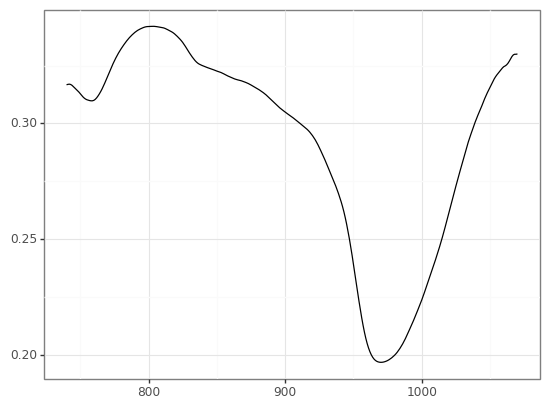

In [7]:
calibration_fn = './calibration.json'
#data_fn        = './01_rawdata/log_extracted/scan_from_log_20200604_143721.json' # Tree bark
data_fn        = './01_rawdata/log_extracted/scan_from_log_20211020_105957.json' # Skin

# Now set up device
scio = scio_analyse() # Create an instance for this device address

#scio.load_calibration_file()
#print(scio.calibration_data)

#refl = scio.run_parsing(data_fn, calibration_fn, silent=False)
#print(refl)

hex_data, b64_data, spec_data = scio.run_log_parsing_test(data_fn, silent=False)

sample_b64 = base64.urlsafe_b64decode(b64_data['sample']).hex()

refl = scio.parse_scan_nocal(b64_data)

#print('From B64:', sample_b64)
#print('From raw:', hex_data['sample'])

print('Done...')

# Show figure
x_data = list(range(700, 1100, 1))
print(x_data)
print(len(refl))
print(len(spec_data)*4)

x_data = list(range(740, 1071, 1))
from plotnine import *
plt = ggplot()
plt = plt + geom_line(aes(x=x_data, y=spec_data))
plt = plt + theme_bw()
print(plt)

In [ ]:
print(struct.unpack('>H', bytes.fromhex('0290')))
print(struct.unpack('<H', bytes.fromhex('0807')))

In [ ]:
test_sample = 'AAAAAEPShV3QZQkQrEMaGczSBHmRAx9vvYWQf5CT3uxpVhfFfJVOz5jTJXqC0cvvR8z9ywCFQEOOoVecSgCpfmu2u9sprzJi9N3htTaj3d4fZncKBXdP1qaEpJsrpMgW1atr1cl49I5GqzNpe7TswE1mYpExw9S_La4DBPEclViGqG2tPRGBmmsSINmXIAQuqArHACwktkEwdtYU91tHXvFkSTaqOMK6r7oVR5sJJ0WnhwOauXg1ww0Si1GMmGrmA2gGp-nlC1FEb3Qlv2Fe7mA7H4OHpQU6Mam82o9ERRN5p24wdDD7jdDIRSdYTNWJv842wNjJ4ccQzts2H_exdWJueUUQ5uraXMhIbOnutdiu2KB8hwpjI1CRI8K4SfJnP9faFN7rDqHc_8oNP-cSZdPBT7BBRBkOWIArV8h0kyQJ3xSKp9ix1s8hbVOUzqCFBizipgKprpsfepL_XCZw__xKv_89QegFDzaSQzMatCUtWytFXN906IqLj2Lh89omtYzasvxYlSA2FC2pdp3NnoPnVk6Tbofg4qouWDxEUlZcsd_fbUgd3zQZeveToG4MiNcmAIUIM8xpnJXeAIDiHkEliSpSrzLIsjeSCZT_S_8YIsUDYDSHDd6D7UZ-0cMNOqNkWu-nLN8Gn5D7CVRmZkZLlfqASh57O2fw77u_Xm1-xmRFOeyxLxqo-IeVy70Dl5csbv5hBCTMn7uWwTywJzZ9vCUg_cjTqPMwO0wKcJCkeVja2H0SvrP-v0AJDpp7XOxGmGmWyzmfwR95N9gHscLKV2_atWGii7XIws2kO7gfgi0QmiFnMLxupvJztHdqeGCKSDkJ_2OEQ9nb2xdCT9M12swTLyRs2ebiExE3Wg6p7_xXDUbgRcA_nAOeHo_cByeJrRWZGP-LoBPCD47Qc8KnwSWhjmMRUxx-TEzjm_oUyNIT1ADtc_olU0Uo82bX39rOMN0-ASMGnzRtvEBl2tampw7GLqHxL4GPsoHncaSdjU258VapGM_NnbrsHtP4QmS-VkrAFcCG1aBM7wg6IjoGiDIW1ltpAq9dHRLs4qHI_1LeplRhVcK1HWG3d_QJfUM0YVQTJXAOA7SCD4KMrTO_eNDRf5Y5KnYmjsHM944QrGHnkB0-RbqwY_L641a7-wjowsGUTYDOneVDUw08_Tsbee_cdUXY0ZKSZn7Ojn916tFY1k2yE52dp-AvALI4ULazX-M8eSzcCyZhVjTV99meyK5TLTjmRrtIffu6A4mctLLnk-nQ0Qe8vka2E7uf7FAD_EfzxnjzMIViFsdMC3IzfTQPNRFF8_58dkt8pKftQF2I8aJVGiBiTWXqy9hMXdun9KvAI2uLB03qttJDezkuS0cNup35cdBke4hHrGyaeTmds4oVmVG2zxvHjRIsZ0NW7HuZYaBiGFxiyM4nDnJqmR5vImQczhFzcN9ACXbzqN_-ry-KZ50WFfEMt_r-eO7YTlsP_WTI-wgITFuoNNpXkYkv0m_VcgnyfGMoj77Kd8ZCQgG0bgtkhom8B_7icnzbV38Dc6Pa1gcuLCRVqD18ZwAPw5_FI7OM4H_6-zmaidTlTYbQ4fJIPcfUQF2EyIbhrEdMenXlosoOOd6gktr9wytydkQ4pqIjpqehJMyD0J4QxM1l080X_Meco1TgRZkfW-EakTCFyceqSGjNM9DXxHZJ-rl8GJzFuPyt58TV70nh5wGSgtxY2IDu7nTkykGZullY9l6IcskvdubPRnB9GpNDfgINOP-lqZQFY_xD2jOHDB0SsGh_YigOT5vv3ARN7O7WE9w8H9WJdtt1_sMeoLVgyzQFSz7dfzlpHPN6BgKNX-4B2yUBYZvrtZ-1iBPtWeH5kSDH34RCuslaX6iySbMx5RHqOlNPlx2y1TgIQ-3YTP9R8Z49_kiVn1XTdpvvBgOv2CWBSwXoP4hQuYWjqckDrsPO7jmvFR6FGfzKKNCfCO3F4ak3pr3hAK4pJs2wHgVHJ-Pe5tXWw0jXPWXZIx4l_cZnCbXoGvgc8QBpt8oj40w3r8uqqKcHzz7qr1PE_rnKaNamErxdMWoHf_qqLbHjIX7bmEFiJQooqZVE5INYTskOKpb-ar2ttEIztEPA_ylOW9kcAnHJNPzGIj4yALjQvqTat20_LALeoh6QGQs1okngMuQS8Kefd6lffi79WUt-YJvHjXL1HneXQRZl2fMTWK3T8TyYyL8-K38jzTwfz2L7xq9wcbYa4HkRuPInsteP1mY3KabgQQRRfG6FD0Gs3Ao7y0HbLbKfjY9LU3ZuN4PA_uqZPmVDVURRzTIpagnHJJkDvZLY4IYwnL--H1qWHLrwWqOntTYPTQPPkStDVoL_qiqsfroZYDgTWr-X5ADKpDumCaYHtZFrilDjzb-6vcUI'

sample_bytes = base64.urlsafe_b64decode(test_sample)

print(len(sample_bytes))
print(sample_bytes.hex())

test_sample = 'AAAAAOp1IDt2sDXjiCAmmKUIf8P-UY3KdjodURTElAeQz-_lyjx2QjNRB3wCMQTWamkIV-SLRWeG78QvxiRuSAH2Ayk8mvdE4081PSSL5D-IF2SGJQnJxO9ZTKFOFUbF_0-_txCL670XhA4nV2fCd9q91He_TWyPmSJgkAMfXsfV1qMa8JYVcdLorUfLMNuO-3Q-Odicl_p65vHLimE7RVdvpoM46o41KZOc_Qnrhrtph-R4bd0iw8ThPYb-cHMJNSIuUqbtxx3n509jGTJaBclTJsFSi_VDPQ700vbZRn2bEmHJUAr3O5KXD3BziwZQw844qlwRR6sixZVy3CSfZ1AcJz0nseZn4VfVQ_CwlJLA_9ly4z8YhOKeWcpdEuTeyut2lAlWba8HLnonzMvJmlEy_LAXnUDZp_pndJlhBh8GQXxbr4Z57idajD-n5PjCzxXFAhYVp2IFhw1Iv8tSpf8iPZ9Hu_u3udMke0lrxo6WojdoZjEI9tX8mYXvxclK7a52RgJ3L0HBBuPy10YWNdWsYgo3H2UYAJ_XrYZxO4VMRH7B3NS_zH_J8hS6w8mW_9hXpgNeTV7zdoHO819FTkkcXIthwwLfcomVatcGQcoBGuVx4FCb5hKa8tjj3f96aAjuvGJ8O-VAELU8RBq7AvSumzvr8qVGb1J5PQVeZRowx3sqwK4YWbqS1imDhfTwp2J-JQgfTrIreaQ234P_Uzeofk1mLB7i32ameWG0J6HsixanjwKjXpO7Deywp0aMUDqHYO-nULwo3Rjw_4W4m91H6Rit_H3-u3EGX89xHssqdwtjgDJCfH_zcxn5xnLM8WqBRzNOdCTXnoO5LwB4vBPItwfvqYkFlZYDLh3gDbRiXEIKYpD5GIO_cZd2lexL0WfeD_wcuq3LpuCTlIxeP_8xyBt_rfrSN4G3mD6YyZJr6asqStehI_3JapQkpy6BnyldUYs50CVcXGdv45Ere57EBTKIiE3ze4KkiN1eAG5wp2LTriQdLC9R4Ia0RIPqohAXF3XFyAXX77ZdaQSnhqcq8RvVv_aUfiBTYaEdVYnmW9MhOYTMeKDfC262oF5ImwZTr81OJPtQi6-JjpFBMXfoe8O0ojY1HZeS4fCj0ruAFkFp2SIr1sVFMIlrD5FPVM_5NLfBoX_0iwLVqspycyzFrcWZp6HZdxnIiqfDVYq0G3CLYhOpG8dqNJdQcdmPXZHMTh6Ba7f6oAPEXFFWxUVbaIaq_gudtjParQCE6q-Ucuwk-gWniicvR0p0H7I2WqgvabxVAG192aA7iaCcSddKOZiL8wPoB_ORHy5s-UG-1l-1GJdiEQemJ6ml0w24XWQIBbcAF9Mb1UgHe3yi9n2sixsyti0Wzu5wlQys-YEVjHMW4ggJ6d-55MG0ff05KYvgo0bGElASmu7krMa6fAOr8IPq9YTWZsfrkvrRGvxE2HuPbGetwTvvPPm0OZOY2P5gkoR2ozg2d161Zh-15OyxCvObcBfskH7a7t3b1OyqY8He8cH0qJhb3BVHsv3odVXKZzydItqX5NzEOZ7bsPJ_56CuRa1e3AW-98MoaIoaHO80OrbSg6COhdA0uBuYak1_5ekestdwpIsNWW2P451bcYSCUrw7HcXKMahPk99GRatZYGCp4LzEWrXSwVsRse4F9u_ezZKpLoxyjn_8mw4QL-75qPKdptemyfwUHrpdmnJjctW0SSzeyztucwTnkeKvcpLHblpXbC1-9eCPYDlXua-WmHkVX1XzL9B_sAqpr1TJJW6fUG1mqDNJ8PwCZWBQJRgx3ICds9itU1LPlkhhdbFwtPdhNkaeIB7CGij3MPTQdlle_eBWUC8c-R9cHDz5KceAe2mLsTAZqp6P1o-x9aX_ayzK'

sample_bytes = base64.urlsafe_b64decode(test_sample)

print(len(sample_bytes))
print(sample_bytes.hex())

In [ ]:
print(400*4)
print(1656 - 400*4)
print(1800 - 400*4)

# encryption is alway in blocks of 16 bytes
1600/16